## Data Downloader

This Jupyter notebook downloads data about globally top selling games from digital gaming platform Steam. These data contain title, release date and information about reviews and prices of individual games. Output of this Downloader is CSV file.

First, we download a few packages necessary for our downloader to be able to scrape data from Steam webpage, then other packages help us display raw data and pandas help us to create the dataframe.

In [162]:
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup
import pandas as pd
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

We begin by creating a class, which we call 'Downloader'. Functions of few first attributes of this downloader come naturally from their names. Then we create attributes 'dataf', 'hoarder' and 'download_data'. As the list of games is too long for just one webpage, Steam saved it in more than 600 webpages in total. Thus, downloading our data works in following way, using  'download_data' attribute:
- It begins by creating a list of urls of given number of pages (starting from the first one) using 'hoarder' attribute.
- Then it uses 'dataf' attribute, which downloads HTML for every url in the list, applies first few attributes of class 'Downloader' and creates pandas dataframe of data for every given url.
- Last, 'download_data' appends dataframe for every url to one large dataframe we want to end up with. It also assigns indexes to individual games.

In [163]:
pages = 5

class Downloader:
    def __init__(self, link):
        self.link = link
        self.uClient = uReq(link)
        self.page_html = self.uClient.read()
        self.uClient.close()
        self.soup = BeautifulSoup(self.page_html, "lxml")
        
    
    def get_titles(self):
        td = self.soup.findAll('span', {"class":"title"})
        titles = []
        for ind in td:
            # lstrip and rstrip remove symbols from sides, strip removes white spaces
            try:
                titles.append(str(ind).lstrip('<span class="title">').rstrip('span>').rstrip('</'))
            except:
                titles.append("Title not available")                
        return titles
    
    def get_release_dates(self):
        td = self.soup.findAll('div', {"class":"col search_released responsive_secondrow"})
        release_dates = []
        for ind in td:
            if ind.text != "":
            # lstrip and rstrip remove symbols from sides, strip removes white spaces
                try:
                    release_dates.append(str(ind).rstrip('</div>').split(">")[-1])
                except:
                    release_dates.append(None)
            else:
                release_dates.append(None)
        return release_dates
    
    def reviews(self):
        tds = self.soup.findAll('div', {"class":"col search_reviewscore responsive_secondrow"})
        reviews = []
        for td in tds:     
            try:
                children = td.findChildren('span', recursive=False)
                for ind in children:
                    # lstrip and rstrip remove symbols from sides, strip removes white spaces
                    try:
                        reviews.append(str(ind).split("html=")[-1])
                    except:
                        reviews.append(None)
            except:
                reviews.append(None)
        return reviews
     
    def get_share_positive_reviews(self):
        text = self.reviews()
        shares = []
        for percent in text:
            try:
                shares.append(percent.split("%")[0].split("br&gt;")[1])
            except:
                shares.append(None)
        return shares
        
    def get_number_user_reviews(self):  
        text = self.reviews()
        numbers = []
        for number in text:
            try:
                start = number.find("of the ") + len("of the ")
                end = number.find(" user reviews")
                numbers.append(number[start:end].replace(",",""))
            except:
                numbers.append(None)
        return numbers
        
    def get_prices(self):

        td = self.soup.findAll('div', {"class":"col search_price_discount_combined responsive_secondrow"} or 
                          {"class":"col search_price discounted responsive_secondrow"})
        prices = []
        for ind in td:
            try:
                if "888888" not in str(ind):
                    try:
                        if (len(str(ind).split("\r\n")[-1].split("</div>\n</div>")[0].strip()) <10):    
                            prices.append(str(ind).split("\r\n")[-1].split("</div>\n</div>")[0].strip().replace("€","").replace(",",".").replace("-","0").replace("Free","0")) 
                        else:
                            prices.append(None)
                    except:
                        prices.append(None)
                else:
                    start1 = str(ind).find("><strike>") + len("><strike>")
                    end1 = str(ind).find("</strike>")
                    prices.append(str(ind)[start1:end1].replace("€","").replace(",",".").replace("-","0").replace("Free","0"))
            except: 
                prices.append(None)
        return prices
    
    def get_price_after_sale(self):

        td = self.soup.findAll('div', {"class":"col search_price_discount_combined responsive_secondrow"} or 
                          {"class":"col search_price discounted responsive_secondrow"})
        sales = []
        for ind in td:
            if "888888" not in str(ind):
                sales.append(None)
            else:
                try:
                    if len(str(ind).split("br/>")[-1].split("€")) < 10:
                        sales.append(str(ind).split("br/>")[-1].split("€")[0].strip().replace(",",".").replace("-","0").replace("Free","0"))
                    else:
                        sales.append("0")
                except:
                    sales.append("0")
        return sales
    
    
    def get_rate_of_sale(self):

        td = self.soup.findAll('div', {"class":"col search_price_discount_combined responsive_secondrow"} or 
                          {"class":"col search_price discounted responsive_secondrow"})
        percent = []
        for ind in td:
            if "888888" not in str(ind):
                percent.append(None)
            else:
                try:
                    start = str(ind).find(">\n<span>-")+len(">\n<span>-")
                    end = str(ind).find("%")
                    percent.append(str(ind)[start:end])
                except:
                    percent.append(None)
        return percent
    
    def dataf(self):
        titles = self.get_titles()
        dates = self.get_release_dates()
        share_reviews = self.get_share_positive_reviews()
        number_reviews = self.get_number_user_reviews()
        normal_prices = self.get_prices()
        sale_price = self.get_price_after_sale()
        sale_rate = self.get_rate_of_sale()
        
        
        self.data = pd.DataFrame({
             'Title': pd.Series(titles),
             'Release date': pd.to_datetime(pd.Series(dates),format='%d %b, %Y', errors = 'coerce'),
             'Share of positive reviews (in %)': pd.to_numeric(share_reviews, errors='coerce'),
             'Total number of reviews': pd.to_numeric(number_reviews, errors='coerce'),
             'Normal price (€)': pd.to_numeric(normal_prices, errors='coerce'),
             'Discounted price if there is a sale (€)': pd.to_numeric(sale_price, errors='coerce'),
             'Sale rate (in %)': pd.to_numeric(sale_rate, errors='coerce')})
        return self.data
     
    def total_games(self):
        total_games = int(self.soup.find('div', {"class":"search_pagination_left"}).text.split("of")[1].strip())
        return total_games
    
    def last_page(self):
        last_page = int(np.ceil((self.total_games())/25))
        return last_page
            
    def hoarder(self):
        urls = [] 
        for i in range(self.last_page()):
            urls.append(self.link + f"&page={1+i}")
        return urls
    
    def download_data(self):
        urls = self.hoarder()
        Frame = pd.DataFrame()
        for url in urls:
            Frame = Frame.append(pd.DataFrame(data = Downloader(url).dataf()))
        Frame.index = range(self.total_games())
        return Frame

This is the link for Steam page of global top sellers ordered by reviews.

In [164]:
link = 'https://store.steampowered.com/search/?sort_by=Reviews_DESC&os=win&filter=globaltopsellers'

# The Data

First, we initialize the link in order to continue working with it. Next, we can apply the 'download_data' attribute and take a look at the craped data.

In [165]:
first = Downloader(link)
#first.download() # in order to explore page html in a reasonable way, one can use online javascript beautifier, available at:
# beautifier.io
df = first.download_data()
df


,Title,Release date,Share of positive reviews (in %),Total number of reviews,Normal price (€),Discounted price if there is a sale (€),Sale rate (in %)
0,The Witcher 3: Wild Hunt - Expansion Pass,2015-05-19,99,3351,24.99,NaN,NaN
1,Senren＊Banka,2020-02-14,99,2854,29.99,NaN,NaN
2,A Short Hike,2019-07-30,99,2757,6.59,NaN,NaN
3,Aseprite,2016-02-22,99,2751,14.99,NaN,NaN
4,Doki Doki Literature Club Fan Pack,2017-09-22,99,1498,9.99,NaN,NaN
...,...,...,...,...,...,...,...
14473,Men of War: Assault Squad 2 - Cold War,2019-09-12,17,539,21.99,NaN,NaN
14474,Far Cry® 5 - Dead Living Zombies,2018-08-28,17,585,7.99,3.99,50.0
14475,Command &amp; Conquer 4: Tiberian Twilight,2010-03-16,17,2340,19.99,NaN,NaN
14476,Tom Clancy's Ghost Recon® Wildlands - Narco Road,2017-04-25,16,501,14.99,NaN,NaN


# Saving the data as CSV file

Now we can save the data as CSV file.

In [ ]:
#df.to_csv('steam_global_sellers_by_reviews')

In [272]:
#%matplotlib inline

class Summary:
    
    def __init__(self, data):
        self.data = data
        
    def get_pages(self):
        pages = int(np.ceil(len(self.data)/25))
        return pages
        
        
    def basic_summary(self):
        number = self.data.iloc[:,6].count()
        sales = [int(x) for x in self.data.iloc[:,6].dropna()]
        new_price = np.array([x for x in self.data.iloc[:,5].dropna()]).astype(float)
        discount = np.array([x for x in self.data.iloc[:,6].dropna()]).astype(float)
        old_price = self.data[['Normal price (€)','Sale rate (in %)']].dropna().iloc[:,0]
        
        mean_of_review = round(self.data.iloc[:,3].dropna().mean(),1)
        
        return {print('Basic summary: '),
                print(f'The number of items on sale from the first {self.get_pages()} pages is {number}.') ,
                print(f'The mean discount is {round(np.mean(sales),2)}%.'),
                print(f'The average price before sale is {round(np.mean(old_price),2)}€, with the average price after sale being {round(np.mean(new_price),2)}€.'),
                print(f'The average number of reviews on a game from the first {self.get_pages()} pages is {mean_of_review}.')
               }


    def price_hist(self):
        new_price = np.array([x for x in self.data.iloc[:,5].dropna()]).astype(float)
        discount = np.array([x for x in self.data.iloc[:,6].dropna()]).astype(float)
        old_price = self.data[['Normal price (€)','Sale rate (in %)']].dropna().iloc[:,0] #original prices of items on sale
        #all_prices = np.array([x[:-1].replace(',', '.').replace("-","0") for x in self.data.iloc[:,4].dropna()]).astype(float)
        
        #all_price_hist = pd.Series(all_prices).plot(kind="hist",bins=20, alpha=0.8, figsize=(10,5),color="blue", edgecolor = "red",linewidth=3, label="All prices")
        old_price_hist = pd.Series(old_price).plot(kind="hist",
                                                   bins=20, 
                                                   alpha=0.8, 
                                                   figsize=(10,5),
                                                   color="green", 
                                                   edgecolor = "blue",
                               
                                                   linewidth=3, 
                                                   label = "Prices before discount")
        new_price_hist = pd.Series(new_price).plot(kind="hist",
                                                   bins=20, 
                                                   alpha=0.8, 
                                                   figsize=(10,5),
                                                   color="orange", 
                                                   edgecolor = "green",
                                                   linewidth=3, 
                                                   label = "Discounted Prices")
        
        plt.legend()
        plt.ylabel('Frequency', size='x-large')
        plt.xlabel('$$$', size='x-large')
        return print(), plt.show() 
    
    def release_hist_total_year(self):
        release = self.data.iloc[:,1].dropna()
        release_all = release.groupby(release.dt.year).count()
        release_all.append
        release_all.plot(kind="bar", 
                         width= 1,
                         color="blue", 
                         alpha=0.8, 
                         figsize=(10,5), 
                         edgecolor = "red",
                         linewidth=3, 
                         label = "Release date of all games")
        
        plt.legend()
        plt.title("Number of games released by Year")
        plt.ylabel('Frequency', size='x-large')
        plt.xlabel('Release date (Year)', size='x-large')
        return print(), plt.show()
    
    def release_hist_sale_year(self):
        release = self.data.iloc[:,1].dropna()
        release_sale = self.data.groupby(release.dt.year)['Discounted price if there is a sale (€)'].count()
        release_sale.plot(kind="bar", 
                          width= 1,
                          color="blue", 
                          alpha=0.8, 
                          figsize=(10,5),
                          edgecolor = "red",
                          linewidth=3, 
                          label = "Release date of items on sale")

        plt.legend()
        plt.title("Number of games on sale released by Year")
        plt.ylabel('Frequency', size='x-large')
        plt.xlabel('Release date (Year)', size='x-large')
        return print(), plt.show()
    
    def release_hist_total_month(self):
        release = self.data.iloc[:,1].dropna()
        release_all = release.groupby(release.dt.month).count()
        release_all.plot(kind="bar",
                         
                         width= 1,
                         color="red",
                         alpha=0.8, 
                         figsize=(10,5),
                         edgecolor = "blue",
                         linewidth=3, 
                         label = "Release date of all games")
        
        plt.legend()
        plt.title("Number of games released by Month")
        plt.ylabel('Frequency', size='x-large')
        plt.xlabel('Release date (Year)', size='x-large')
        return print(), plt.show()
    
    def release_hist_sale_month(self):
        release = self.data.iloc[:,1].dropna()
        release_sale = self.data.groupby(release.dt.month)['Discounted price if there is a sale (€)'].count()
        release_sale.plot(kind="bar", 
                          width= 1,
                          color="red", 
                          alpha=0.8, 
                          figsize=(10,5), 
                          edgecolor = "blue",
                          linewidth=3, 
                          label = "Release date of items on sale")

        plt.legend()
        plt.title("Number of games on sale released by Month")
        plt.ylabel('Frequency', size='x-large')
        plt.xlabel('Release date (Year)', size='x-large')
        return print(), plt.show()

    
    def release_multiple_hist(self):
        rl = self.data.iloc[:,1].dropna().astype("datetime64")
        rl = rl[rl >= '2010-01-01']
        rl = rl[rl <= '2020-01-01']
        colors = np.array(["lightgrey", 
                           "skyblue", 
                           "dodgerblue", 
                           "gold",
                           "lightpink",
                           "mediumorchid", 
                           "lightcoral", 
                           "limegreen", 
                           "indigo", 
                           "chocolate"])
        rl.groupby(by=[rl.dt.month,rl.dt.year]).count().plot(kind="bar",
                                                              width= 1,
                                                              color = colors,
                                                              alpha=0.8, 
                                                              figsize=(10,5),
                                                              edgecolor = "black",
                                                              linewidth=1,
                                                              label = "Release date of items on sale"
                                                             ).axes.xaxis.set_visible(False)
        
        plt.legend(['2010',
                    '2011',
                    '2012',
                    '2013',
                    '2014',
                    '2015',
                    '2016',
                    '2017',
                    '2018',
                    '2019'])
        plt.ylabel('Frequency', size='x-large')
        plt.xlabel('Release date (by months and years)', size='x-large')
        #rl.axes.xaxis.set_visible(False)
        return plt.show()
    
    def release_tab_year(self):
        release = self.data.iloc[:,1].dropna()
        release_all = release.groupby(release.dt.year).count()
        release_sale = self.data.groupby(release.dt.year)['Discounted price if there is a sale (€)'].count()
        average_discount = round(self.data.groupby(release.dt.year)['Sale rate (in %)'].mean(),2)
        average_rating = round(self.data.groupby(release.dt.year)['Share of positive reviews (in %)'].mean(),2)
        sale_ratio = round(release_sale/release_all,4)
        
        release_table_year = pd.concat([release_all,
                                        release_sale,
                                        average_discount, 
                                        sale_ratio, 
                                        average_rating],
                                       axis=1)
        release_table_year = release_table_year.set_axis(['Games',
                                                          'Discounted games',
                                                          'Average discount (%)',
                                                          'Ratio of games on sale',
                                                          'Average rating (%)'],
                                                         axis=1 ,inplace=False
                                                        )
        
        
        fig = plt.figure(figsize = (15, 6))
        ax = fig.add_subplot(111)

        the_table = ax.table(cellText = release_table_year.values,
                    rowLabels = release_table_year.index,
                    colLabels = release_table_year.columns,
                    loc = "center",
                    bbox=[0, -1.03, 1.5, 2]
                    )
        ax.set_title("Summary of the offered games by year of release",
                     fontsize=23, 
                     loc="center"
                    )
        ax.axis("off")
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(20)
        return print(), plt.show()
           
    def release_tab_month(self):
        release = self.data.iloc[:,1].dropna()
        release_all = release.groupby(release.dt.month).count()
        release_sale = self.data.groupby(release.dt.month)['Discounted price if there is a sale (€)'].count()
        average_discount = round(self.data.groupby(release.dt.month)['Sale rate (in %)'].mean(),2)
        average_rating = round(self.data.groupby(release.dt.month)['Share of positive reviews (in %)'].mean(),2)
        sale_ratio = round(release_sale/release_all,4)
        
        release_table_month = pd.concat([release_all,
                                         release_sale,
                                         average_discount, 
                                         sale_ratio, 
                                         average_rating],
                                        axis=1
                                       )
        release_table_month = release_table_month.set_axis(['Games', 
                                                            'Discounted games', 
                                                            'Average discount (%)', 
                                                            'Ratio of games on sale',
                                                            'Average rating (%)'],
                                                           axis=1 ,
                                                           inplace=False
                                                          )
        release_table_month = release_table_month.set_axis(['January', 
                                                            'February', 
                                                            'March', 
                                                            'April', 
                                                            'May', 
                                                            'June', 
                                                            'July', 
                                                            'August', 
                                                            'September', 
                                                            'October', 
                                                            'November',
                                                            'December'],
                                                           axis=0 ,
                                                           inplace=False
                                                          )
        
        fig = plt.figure(figsize = (15, 4.5))
        ax = fig.add_subplot(111)

        the_table = ax.table(cellText = release_table_month.values,
                    rowLabels = release_table_month.index,
                    colLabels = release_table_month.columns,
                    loc = "center",
                    bbox=[0, -1.04, 1.5, 2]
                            )
        ax.set_title("Summary of the offered games by month of release", fontsize=25)

        ax.axis("off")
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(20)
        
        return print(), plt.show()
        
        
    
    def ratings(self):
        
        counted = self.data.groupby('Share of positive reviews (in %)')['Total number of reviews',
                                                                        'Discounted price if there is a sale (€)'
                                                                       ].count()
        sale_ratio = (counted.iloc[:,1])/counted.iloc[:,0]
        means = self.data.groupby('Share of positive reviews (in %)')['Total number of reviews',
                                                                      'Normal price (€)',
                                                                      'Discounted price if there is a sale (€)',
                                                                      'Sale rate (in %)'
                                                                     ].mean()
        
        rating_table = pd.concat([counted,round(sale_ratio,4),round(means,2)], axis=1).sort_index(ascending=False)
        rating_table = rating_table.set_axis(['Games',
                                              'Discounted games',
                                              'Ratio of games on sale',
                                              'Avg. review count', 
                                              'Avg. price (€)', 
                                              'Avg. discounted price (€)',
                                              'Avg. discount rate (%)'],
                                             axis=1 ,
                                             inplace=False)
        return rating_table
    
    def summary_table(self):
        fig = plt.figure(figsize = (20, 23))
        ax = fig.add_subplot(111)
        
        the_table = ax.table(cellText = self.ratings().values,
                    rowLabels = self.ratings().index,
                    colLabels = self.ratings().columns,
                    loc = "center"
                    )
        ax.set_title("Summary of offered games by the share of positive reviews from Steam users",
                     fontsize=20,
                     loc= "center"
                    )

        ax.axis("off")
        
        return plt.show()
    
    def sale_ratio_hist(self):
        sale_ratio_hist = pd.Series(self.ratings()['Ratio of games on sale']).plot(kind="bar",
                                                                                   alpha=0.8, 
                                                                                   figsize=(20,5),
                                                                                   color="green", 
                                                                                   edgecolor = "blue",
                                                                                   linewidth=3, 
                                                                                   label = "Prices before discount")
        plt.ylabel('Ratio of games on sale', size='x-large')
        plt.xlabel('Rating', size='x-large')
        plt.gca().invert_xaxis()
        
        return print(),plt.show()
    
    def average_discount_hist(self):
        sale_ratio_hist = pd.Series(self.ratings()['Avg. discount rate (%)']).plot(kind="bar",
                                                                                   alpha=0.8, 
                                                                                   figsize=(20,5),
                                                                                   color="red", 
                                                                                   edgecolor = "blue",
                                                                                   linewidth=3, 
                                                                                   label = "Prices before discount")
        plt.ylabel('Average discount rate (%)', size='x-large')
        plt.xlabel('Rating', size='x-large')
        plt.gca().invert_xaxis()
        
        return print(),plt.show()
    
    
        

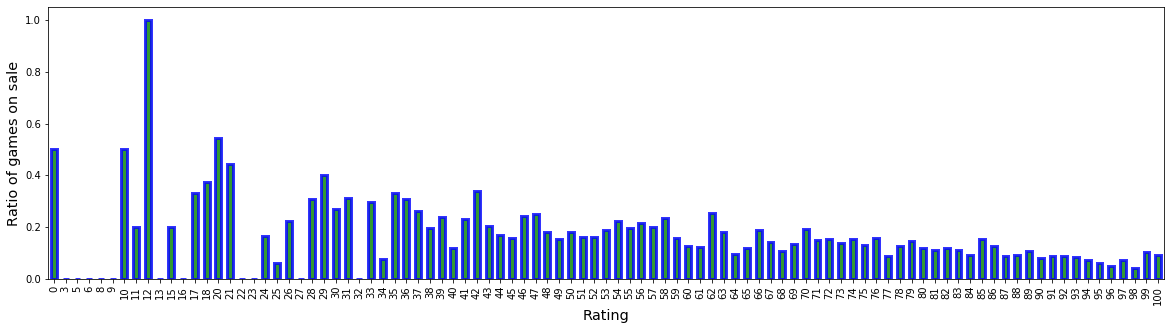

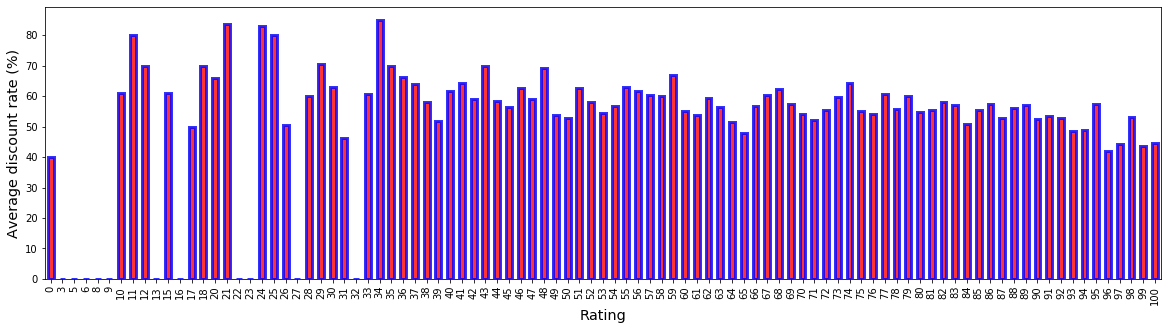

(None, None)

In [273]:
xx = Summary(df)
#xx.basic_summary()
#xx.price_hist()
#xx.release_hist_total_year()
#xx.release_hist_sale_year()
#xx.release_hist_total_month()
#xx.release_hist_sale_month()
#xx.release_multiple_hist()
#xx.release_tab_year()
#xx.release_tab_month()
xx.sale_ratio_hist()
#xx.summary_table()
xx.average_discount_hist()